# Setup

In [1]:
# Get VM CPU and R version
shell_call <- function(command, ...) {
  result <- system(command, intern = TRUE, ...)
  cat(paste0(result, collapse = "\n"))
}
shell_call("grep -m1 'model name' /proc/cpuinfo | awk -F': ' '{printf \" CPU Model: %s \\n \",  $2}'")
shell_call("grep 'cpu cores' /proc/cpuinfo  | awk -F': ' '{a[cores]+=$2}END{printf \"CPU Cores: %s \\n \", a[cores] }'")
shell_call("grep MemTotal /proc/meminfo | awk '{printf \"RAM: %.1fGB \\n \", $2 / 1024 / 1024}'")
shell_call("R --version | head -n 1")

 CPU Model: Intel(R) Xeon(R) CPU @ 2.20GHz 
 CPU Cores: 32 
 RAM: 51.0GB 
 R version 4.4.1 (2024-06-14) -- "Race for Your Life"

In [2]:
# Install Torch

Sys.setenv(CUDA='cpu')
install.packages("torch")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘coro’, ‘safetensors’




In [3]:
# Test Torch installation

library(torch)
torch_rand(4)

torch_tensor
 0.4288
 0.8858
 0.6617
 0.7591
[ CPUFloatType{4} ]

In [4]:
# Install BKTR

install.packages('BKTR')

### From Github (Latest Version)
# install.packages("devtools") # if not installed
# devtools::install_github("julien-hec/BKTR", ref = "main")

# For section 4 side by side plots
# install.packages('ggpubr')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘collections’, ‘png’, ‘plyr’, ‘jpeg’, ‘bitops’, ‘R6P’, ‘ggmap’




In [5]:
# The following block is because Jupyter for R does not print until the end of
# the code block execution. So, with this command we add real time printing.
# See: https://stackoverflow.com/questions/37689694/real-time-printing-to-console-with-r-in-jupyter
trace(what = "print", where = getNamespace("base"), exit = flush.console, print = FALSE)

Tracing function "print" in package "namespace:base"



[1] "print"

# Load Libraries

In [6]:
# Code to run BKTR examples #
# Lanthier, Lei, Sun and Labbe 2023 #

library('BKTR')
library(data.table)
library(ggplot2)
# library('ggpubr')

# Run BKTR

In [7]:
#####################################
#####################################
# Section 5: Simulation-based study #
#####################################
#####################################

#########################################
### 5.1: Estimation of the parameters ###
#########################################

# Set seed and calculation params
TSR$set_params(seed = 1, fp_type = 'float64', fp_device = 'cpu')

# Use specific covariance matrix for simulation
matern_lenscale <- KernelParameter$new(value = 14)
se_lenscale <- KernelParameter$new(value = 5)
spatial_kernel <- KernelMatern$new(lengthscale = matern_lenscale)
temporal_kernel <- KernelSE$new(lengthscale = se_lenscale)

# Simulate data
simu_data <- simulate_spatiotemporal_data(
  nb_locations = 100,
  nb_time_points = 150,
  nb_spatial_dimensions = 2,
  spatial_scale = 10,
  time_scale = 10,
  spatial_covariates_means = c(0, 2, 4),
  temporal_covariates_means = c(1, 3),
  spatial_kernel = spatial_kernel,
  temporal_kernel = temporal_kernel,
  noise_variance_scale = 1)

# Create Regressor
bktr_regressor <- BKTRRegressor$new(
  data_df = simu_data$data_df,
  spatial_kernel = KernelMatern$new(),
  spatial_positions_df = simu_data$spatial_positions_df,
  temporal_kernel = KernelSE$new(),
  temporal_positions_df = simu_data$temporal_positions_df,
  has_geo_coords = FALSE)

# MCMC sampling
bktr_regressor$mcmc_sampling()

# Print Summary
summary(bktr_regressor)

[1] "Iter 1     | Elapsed Time:     0.74s | MAE:  2.9356 | RMSE:  3.7555"
[1] "Iter 2     | Elapsed Time:     0.49s | MAE:  1.1503 | RMSE:  1.4522"
[1] "Iter 3     | Elapsed Time:     0.64s | MAE:  0.8629 | RMSE:  1.0821"
[1] "Iter 4     | Elapsed Time:     0.30s | MAE:  0.8293 | RMSE:  1.0376"
[1] "Iter 5     | Elapsed Time:     0.88s | MAE:  0.8243 | RMSE:  1.0293"
[1] "Iter 6     | Elapsed Time:     0.53s | MAE:  0.8192 | RMSE:  1.0257"
[1] "Iter 7     | Elapsed Time:     0.78s | MAE:  0.8199 | RMSE:  1.0266"
[1] "Iter 8     | Elapsed Time:     0.62s | MAE:  0.8171 | RMSE:  1.0246"
[1] "Iter 9     | Elapsed Time:     1.39s | MAE:  0.8171 | RMSE:  1.0238"
[1] "Iter 10    | Elapsed Time:     0.65s | MAE:  0.8151 | RMSE:  1.0211"
[1] "Iter 11    | Elapsed Time:     0.63s | MAE:  0.8182 | RMSE:  1.0245"
[1] "Iter 12    | Elapsed Time:     0.59s | MAE:  0.8160 | RMSE:  1.0222"
[1] "Iter 13    | Elapsed Time:     0.71s | MAE:  0.8127 | RMSE:  1.0210"
[1] "Iter 14    | Elapsed Time:     0.

In [8]:
# Print Beta Errors (Removing Time and Location columns)
beta_err <- unlist(abs(
    bktr_regressor$beta_estimates[, -c(1, 2)]
    - simu_data$beta_df[, -c(1, 2)]
))
print(sprintf('Beta RMSE: %.4f', sqrt(mean(beta_err^2))))
print(sprintf('Beta MAE: %.4f', mean(abs(beta_err))))


[1] "Beta RMSE: 0.1426"
[1] "Beta MAE: 0.0840"


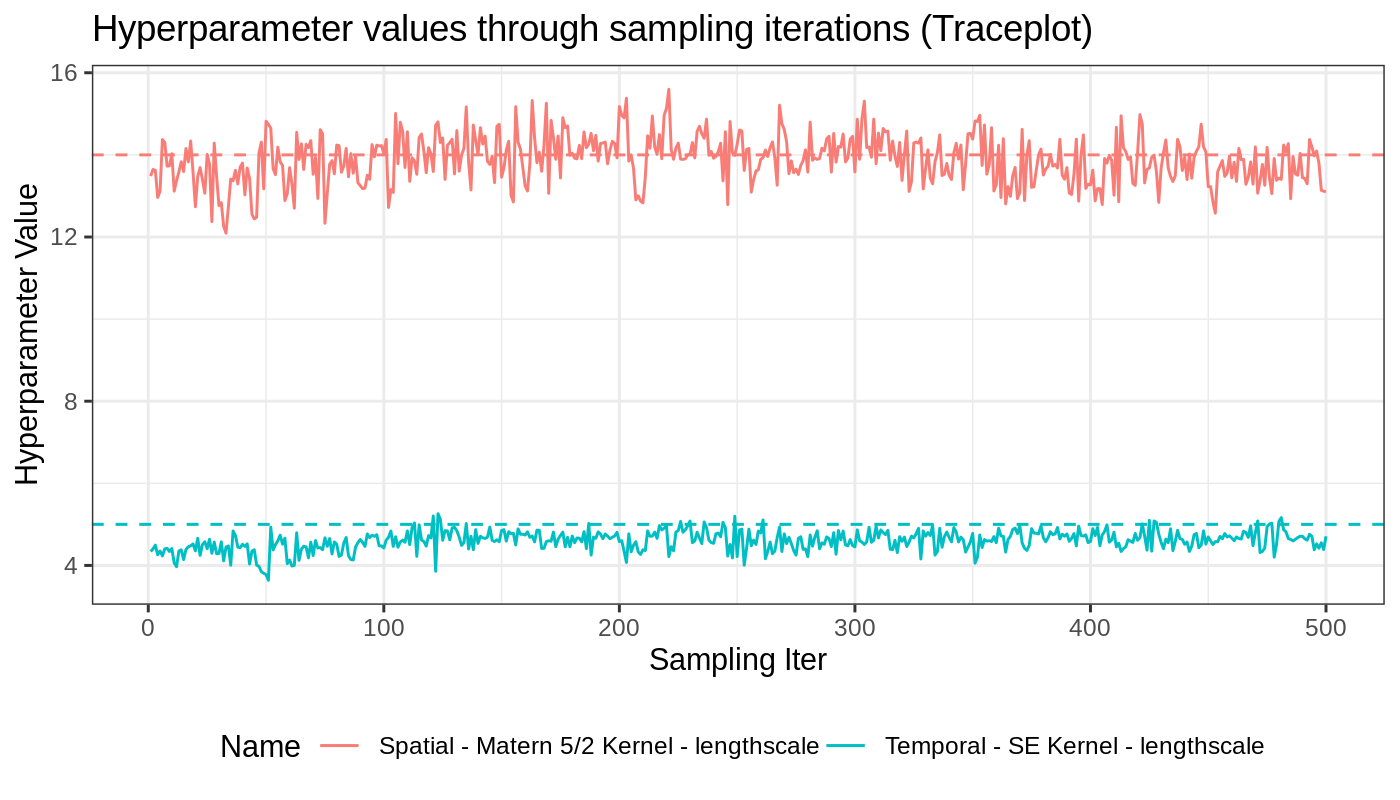

In [9]:
# Create Traceplot (Figure 4)
options(repr.plot.width = 7, repr.plot.height = 4, repr.plot.res = 200)
fig <- plot_hyperparams_traceplot(bktr_regressor, c(
    'Spatial - Matern 5/2 Kernel - lengthscale',
    'Temporal - SE Kernel - lengthscale'
    ), show_figure = FALSE)

col_1 <- '#f87d76'; col_2 <- '#00bfc4';
fig +
    scale_colour_manual(name = 'Name', values = c(col_1, col_2)) +
    geom_hline(yintercept = matern_lenscale$value,
        linetype = 'dashed', col = col_1) +
    geom_hline(yintercept = se_lenscale$value,
        linetype = 'dashed', col = col_2)



Warning message in geom_segment(aes(x = min_y, y = min_y, xend = max_y, yend = max_y), :
“All aesthetics have length 1, but the data has 15000 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”


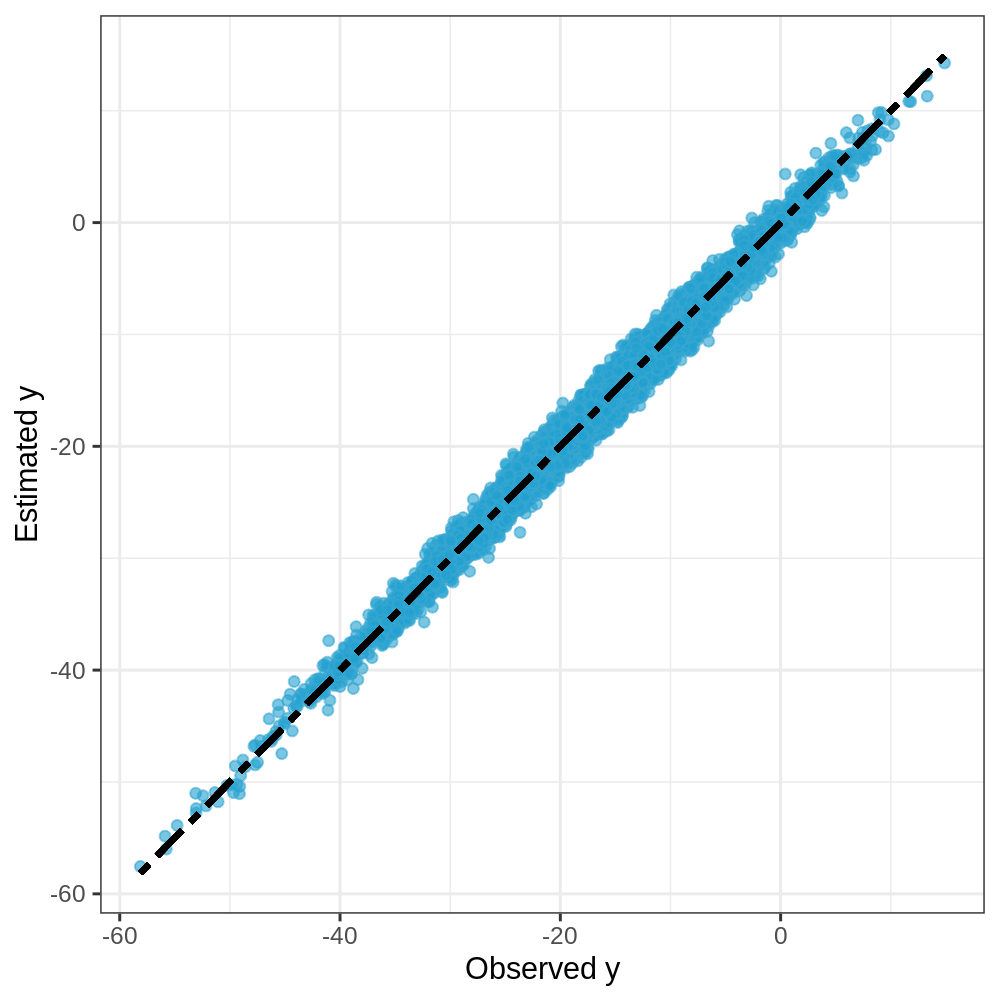

In [10]:
# Plot y estimates (Figure 5)
plot_y_estimates(bktr_regressor, fig_title = NULL)